#Тематическое моделирование песен

In [0]:
import sqlite3
import pickle
import os
import matplotlib.pyplot as plt

In [2]:
!pip install bigartm10

In [0]:
import artm

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Предобработка
Уберем из песен самые частотные, неинформативные слова, самые малочастотные слова, стоп-слова и междометия.

Загрузим список токенизированных песен.

In [0]:
with open('drive/My Drive/Colab Notebooks/Lyrics_X_tok.pkl', 'rb') as f1:
    X_tok = pickle.load(f1)

with open('drive/My Drive/Colab Notebooks/Lyrics_Y.pkl', 'rb') as f2:
    Y = pickle.load(f2)

Составим частотный словарь слов.

In [0]:
import operator

words_counter = {}
for song in X_tok:
    for word in song:
        if word not in words_counter:
            words_counter[word] = 1
        else:
            words_counter[word] += 1
sorted_words_counter = sorted(words_counter.items(), key=operator.itemgetter(1), reverse=True)

In [7]:
print('В наборе данных {} уникальных слова'.format(len(sorted_words_counter)))

В наборе данных 74974 уникальных слова


Найдем слова, которые встретились только один раз.

In [0]:
one_entrance_words = []
for i in range(len(sorted_words_counter)):
    if sorted_words_counter[i][1] == 1:
        one_entrance_words.append(sorted_words_counter[i][0])

Найдем самые частотные, неинформативные слова.

Добавим самые частотные и малочастотные слова в список слов, которые следует убрать.

In [0]:
frequency_excluded = []
for i in range(150):
    frequency_excluded.append(sorted_words_counter[i][0])
frequency_excluded.extend(one_entrance_words)
frequency_excluded = set(frequency_excluded)

Из корпуса nltk загрузим стоп-слова для разных языков (т.к. в данных присутствуют песни на разных языках).

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words())

In [12]:
!pip install stop-words

In [0]:
from stop_words import get_stop_words

stopwords_pypl = []
stopwords_pypl.extend(get_stop_words('english'))
stopwords_pypl.extend(get_stop_words('french'))
stopwords_pypl.extend(get_stop_words('russian'))
stopwords_pypl.extend(get_stop_words('spanish'))
stopwords_pypl.extend(get_stop_words('portuguese'))
stopwords_pypl.extend(get_stop_words('german'))
stopwords_pypl.extend(get_stop_words('italian'))
stopwords_pypl.extend(get_stop_words('norwegian'))
stopwords_pypl.extend(get_stop_words('turkish'))
stopwords_pypl = set(stopwords_pypl)

Загрузим неинформативные слова, которые были собраны вручную.

In [0]:
uninformative = set()
with open('drive/My Drive/Colab Notebooks/Lyrics_Artm/for_delete.txt', 'rt') as f:
    for word in f.readlines():
        uninformative.add(word[:-1])

Создадим словарь с пенями, распределенными по жанрам.

In [0]:
genres = {}
for i, song in enumerate(X_tok):
    genre = Y[i]
    if genre in genres:
        genres[genre].append(song)
    else:
        genres[genre] = [song]

Создадим файлы для каждого жанра в формате vowpal wabbit:

*  уберем слова (самые частотные и малочастотные, неинформативные, стоп-слова, междометия),
*  каждая строка равна песне,
*  каждая строка начинается с вертикальной черты "|" и модальности (в нашем случае модальность одна - текстовая),
*  дальше через пробел идут слова в начальной форме.

In [0]:
repl = '"!.?¿\'«»#№$%&()*+,-—/:;<=>@[\\]^_`{|}~0123456789'

for genre in genres:
    with open('drive/My Drive/Colab Notebooks/Lyrics_Artm/{}.txt'.format(genre), 'wt') as f:
        for song in genres[genre]:
            one_song = ''
            for token in song:
                if token in repl or token in uninformative or token in stopwords_pypl or token in stopwords or token in frequency_excluded:
                    continue
                one_song = one_song + token + ' '
            f.write('|text {}\n'.format(one_song))

##Тематическое моделирование песен каждого жанра

###Jazz: тематическое моделирование 

####LDA модель

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Jazz.txt", data_format="vowpal_wabbit", target_folder="drive/My Drive/Colab Notebooks/Lyrics_Artm/Jazz", 
                                       batch_size=1000)

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Jazz", data_format='batches')

In [0]:
dict_jazz = batch_vectorizer.dictionary

In [0]:
dict_jazz = artm.Dictionary(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Jazz")
dict_jazz.gather(batch_vectorizer.data_path)

In [0]:
T = 5   # количество тем
lda_jazz = artm.LDA(num_topics=T, alpha=0.05, beta=0.01, cache_theta=True,
               num_document_passes=5, dictionary=dict_jazz)
lda_jazz.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)

In [22]:
lda_jazz.perplexity_value

[16039.5322265625,
 2429.23681640625,
 2173.279052734375,
 1998.6170654296875,
 1888.8050537109375,
 1814.2158203125,
 1762.4168701171875,
 1724.21533203125,
 1694.48046875,
 1671.04931640625,
 1652.782958984375,
 1636.93017578125,
 1623.1544189453125,
 1611.816162109375,
 1601.780029296875,
 1592.6536865234375,
 1586.0185546875,
 1580.1236572265625,
 1574.72216796875,
 1570.0555419921875,
 1565.98828125,
 1561.2117919921875,
 1556.794189453125,
 1552.3941650390625,
 1548.790771484375,
 1545.6177978515625,
 1543.00244140625,
 1540.9185791015625,
 1538.9619140625,
 1537.17529296875,
 1535.2685546875,
 1533.4635009765625,
 1531.6868896484375,
 1529.91748046875,
 1527.5904541015625,
 1524.5477294921875,
 1522.158447265625,
 1520.1116943359375,
 1518.4215087890625,
 1516.9210205078125,
 1515.755126953125,
 1514.7320556640625,
 1513.81298828125,
 1512.895751953125,
 1511.62646484375,
 1510.28857421875,
 1509.32421875,
 1508.3363037109375,
 1507.107666015625,
 1506.0472412109375,
 1505.23657

In [23]:
top_tokens = lda_jazz.get_top_tokens(num_tokens=10)
for i, token_list in enumerate(top_tokens):
     print('Topic #{0}: {1}'.format(i, token_list))

Topic #0: ['kiss', 'true', 'may', 'song', 'cry', 'blue', 'seem', 'moon', 'much', 'smile']
Topic #1: ['new', 'people', 'ring', 'blue', 'house', 'happy', 'big', 'send', 'trouble', 'chee']
Topic #2: ['nobody', 'boy', 'yes', 'swing', 'sing', 'comin', 'doo', 'dead', 'lady', 'yi']
Topic #3: ['dance', 'woman', 'rock', 'town', 'honey', 'mama', 'roll', 'foot', 'lord', 'put']
Topic #4: ['trous', 'petits', 'plus', 'tight', 'pum', 'dear', 'trust', "j'ai", 'padam', 'vie']


#### PLSA и ARTM модели

In [0]:
dict_jazz = batch_vectorizer.dictionary

In [0]:
dict_jazz = artm.Dictionary(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Jazz")
dict_jazz.gather(batch_vectorizer.data_path)

In [0]:
T = 5   # количество тем

model_plsa_jazz = artm.ARTM(topic_names=["Theme: "+str(i) for i in range(T)], cache_theta=True, num_document_passes=1,
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dict_jazz)])

model_artm_jazz = artm.ARTM(num_topics=T, topic_names=["Theme: "+str(i) for i in range(T)], cache_theta=True,num_document_passes=1, scores=[artm.PerplexityScore(name='PerplexityScore', dictionary=dict_jazz)],
                        regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.05)])

In [0]:
model_plsa_jazz.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_plsa_jazz.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_plsa_jazz.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                            probability_mass_threshold=0.3))
model_plsa_jazz.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))

model_artm_jazz.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm_jazz.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm_jazz.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                                  probability_mass_threshold=0.3))
model_artm_jazz.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))

model_artm_jazz.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.05))
model_artm_jazz.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=0.5e+5))

In [0]:
model_plsa_jazz.initialize(dictionary=dict_jazz)
model_artm_jazz.initialize(dictionary=dict_jazz)

In [0]:
model_plsa_jazz.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)
model_artm_jazz.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)

Sparsity Phi: 0.686 (PLSA) vs. 0.771 (ARTM)
Sparsity Theta: 0.015 (PLSA) vs. 0.053 (ARTM)
Kernel contrast: 0.910 (PLSA) vs. 0.940 (ARTM)
Kernel purity: 0.919 (PLSA) vs. 0.929 (ARTM)
Perplexity: 1653.779 (PLSA) vs. 1739.084 (ARTM)


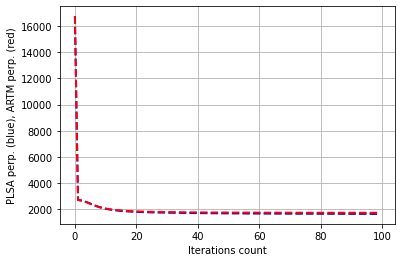

In [30]:
print('Sparsity Phi: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_jazz.score_tracker['SparsityPhiScore'].last_value,
    model_artm_jazz.score_tracker['SparsityPhiScore'].last_value))

print('Sparsity Theta: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_jazz.score_tracker['SparsityThetaScore'].last_value,
    model_artm_jazz.score_tracker['SparsityThetaScore'].last_value))

print('Kernel contrast: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_jazz.score_tracker['TopicKernelScore'].last_average_contrast,
    model_artm_jazz.score_tracker['TopicKernelScore'].last_average_contrast))

print('Kernel purity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_jazz.score_tracker['TopicKernelScore'].last_average_purity,
    model_artm_jazz.score_tracker['TopicKernelScore'].last_average_purity))

print('Perplexity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_jazz.score_tracker['PerplexityScore'].last_value,
    model_artm_jazz.score_tracker['PerplexityScore'].last_value))

plt.plot(range(model_plsa_jazz.num_phi_updates),
            model_plsa_jazz.score_tracker['PerplexityScore'].value, 'b--',
            range(model_artm_jazz.num_phi_updates),
            model_artm_jazz.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA perp. (blue), ARTM perp. (red)')
plt.grid(True)
plt.show()

#print(model_plsa, model_artm)

In [31]:
for topic_name in model_artm_jazz.topic_names:
    print(topic_name + ': '),
    print(model_artm_jazz.score_tracker['TopTokensScore'].last_tokens[topic_name])

Theme: 0: 
['kiss', 'song', 'true', 'may', 'cry', 'mean', 'much', 'seem', 'alone', 'please']
Theme: 1: 
['blue', 'new', 'nothing', 'light', 'people', 'happy', 'everything', 'lose', 'walk', 'someone']
Theme: 2: 
['yes', 'boy', 'nobody', 'sun', 'shine', 'rain', 'sing', 'believe', 'swing', 'somebody']
Theme: 3: 
['play', 'dance', 'music', 'stop', 'town', 'soul', 'place', 'woman', 'honey', 'talk']
Theme: 4: 
['tight', 'mama', 'trust', 'trous', 'joe', 'doo', 'petits', 'plus', 'water', 'treat']


In [32]:
for topic_name in model_plsa_jazz.topic_names:
    print(topic_name + ': '),
    print(model_plsa_jazz.score_tracker['TopTokensScore'].last_tokens[topic_name])

Theme: 0: 
['kiss', 'true', 'song', 'may', 'cry', 'mean', 'much', 'seem', 'alone', 'please']
Theme: 1: 
['blue', 'new', 'light', 'people', 'happy', 'sky', 'everything', 'nothing', 'fly', 'someone']
Theme: 2: 
['yes', 'boy', 'nobody', 'sing', 'swing', 'believe', 'shine', 'somebody', 'sleep', 'big']
Theme: 3: 
['dance', 'play', 'music', 'put', 'talk', 'town', 'soul', 'stop', 'woman', 'honey']
Theme: 4: 
['tight', 'mama', 'trust', 'trous', 'joe', 'doo', 'petits', 'plus', 'pum', 'air']


###Stage & Screen: тематическое моделирование 

####LDA модель

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Stage & Screen.txt", data_format="vowpal_wabbit", target_folder="drive/My Drive/Colab Notebooks/Lyrics_Artm/Stage & Screen", 
                                       batch_size=1000)

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Stage & Screen", data_format='batches')

In [0]:
dict_stage = batch_vectorizer.dictionary

In [0]:
dict_stage = artm.Dictionary(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Stage & Screen")
dict_stage.gather(batch_vectorizer.data_path)

In [0]:
T = 5   # количество тем
lda_stage = artm.LDA(num_topics=T, alpha=0.05, beta=0.01, cache_theta=True,
               num_document_passes=5, dictionary=dict_stage)
lda_stage.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)

In [39]:
lda_stage.perplexity_value

[9621.9384765625,
 2220.72265625,
 1911.9808349609375,
 1715.859130859375,
 1609.926513671875,
 1550.55419921875,
 1516.7880859375,
 1497.637939453125,
 1485.95166015625,
 1477.5413818359375,
 1470.6689453125,
 1465.212646484375,
 1461.0450439453125,
 1457.5816650390625,
 1454.7738037109375,
 1452.3818359375,
 1449.956298828125,
 1448.2098388671875,
 1446.673583984375,
 1445.4400634765625,
 1444.3673095703125,
 1443.26025390625,
 1442.1602783203125,
 1441.1600341796875,
 1440.0733642578125,
 1439.0032958984375,
 1437.8673095703125,
 1436.215087890625,
 1434.4893798828125,
 1433.0423583984375,
 1431.7437744140625,
 1430.1798095703125,
 1429.2398681640625,
 1428.36572265625,
 1426.6395263671875,
 1424.836181640625,
 1423.8775634765625,
 1423.17626953125,
 1422.177978515625,
 1421.048095703125,
 1419.3865966796875,
 1417.8514404296875,
 1416.4390869140625,
 1414.578125,
 1411.299072265625,
 1408.506103515625,
 1406.348388671875,
 1404.61865234375,
 1400.908203125,
 1398.19970703125,
 1396

In [40]:
top_tokens = lda_stage.get_top_tokens(num_tokens=10)
for i, token_list in enumerate(top_tokens):
     print('Topic #{0}: {1}'.format(i, token_list))

Topic #0: ['kiss', 'forever', 'song', 'sing', 'angel', 'darling', 'sky', 'music', 'high', 'may']
Topic #1: ['new', 'tonight', 'big', 'blue', 'everybody', 'happy', 'hot', 'play', 'rain', 'lord']
Topic #2: ['yes', 'woo', 'sir', 'bit', 'town', 'put', 'rich', 'yellow', 'may', 'ask']
Topic #3: ['may', 'wait', 'true', 'much', 'another', 'walk', 'nothing', 'cry', 'must', 'place']
Topic #4: ['eta', 'doo', 'hajji', 'plus', 'cœur', 'brother', 'sol', "l'amour", 'pussycat', 'vie']


#### PLSA и ARTM модели

In [0]:
dict_stage = batch_vectorizer.dictionary

In [0]:
dict_stage = artm.Dictionary(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Stage & Screen")
dict_stage.gather(batch_vectorizer.data_path)

In [0]:
T = 5   # количество тем

model_plsa_stage = artm.ARTM(topic_names=["Theme: "+str(i) for i in range(T)], cache_theta=True, num_document_passes=1,
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dict_stage)])

model_artm_stage = artm.ARTM(num_topics=T, topic_names=["Theme: "+str(i) for i in range(T)], cache_theta=True,num_document_passes=1, scores=[artm.PerplexityScore(name='PerplexityScore', dictionary=dict_stage)],
                        regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.05)])

In [0]:
model_plsa_stage.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_plsa_stage.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_plsa_stage.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                            probability_mass_threshold=0.3))
model_plsa_stage.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))

model_artm_stage.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm_stage.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm_stage.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                                  probability_mass_threshold=0.3))
model_artm_stage.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))

model_artm_stage.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.05))
model_artm_stage.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=0.5e+5))

In [0]:
model_plsa_stage.initialize(dictionary=dict_stage)
model_artm_stage.initialize(dictionary=dict_stage)

In [0]:
model_plsa_stage.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)
model_artm_stage.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)

In [47]:
print('Sparsity Phi: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_stage.score_tracker['SparsityPhiScore'].last_value,
    model_artm_stage.score_tracker['SparsityPhiScore'].last_value))

print('Sparsity Theta: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_stage.score_tracker['SparsityThetaScore'].last_value,
    model_artm_stage.score_tracker['SparsityThetaScore'].last_value))

print('Kernel contrast: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_stage.score_tracker['TopicKernelScore'].last_average_contrast,
    model_artm_stage.score_tracker['TopicKernelScore'].last_average_contrast))

print('Kernel purity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_stage.score_tracker['TopicKernelScore'].last_average_purity,
    model_artm_stage.score_tracker['TopicKernelScore'].last_average_purity))

print('Perplexity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_stage.score_tracker['PerplexityScore'].last_value,
    model_artm_stage.score_tracker['PerplexityScore'].last_value))

plt.plot(range(model_plsa_stage.num_phi_updates),
            model_plsa_stage.score_tracker['PerplexityScore'].value, 'b--',
            range(model_artm_stage.num_phi_updates),
            model_artm_stage.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA perp. (blue), ARTM perp. (red)')
plt.grid(True)
plt.show()

#print(model_plsa, model_artm)

Sparsity Phi: 0.674 (PLSA) vs. 0.749 (ARTM)
Sparsity Theta: 0.010 (PLSA) vs. 0.024 (ARTM)
Kernel contrast: 0.884 (PLSA) vs. 0.900 (ARTM)
Kernel purity: 0.899 (PLSA) vs. 0.907 (ARTM)
Perplexity: 1550.176 (PLSA) vs. 1573.812 (ARTM)


In [48]:
for topic_name in model_artm_stage.topic_names:
    print(topic_name + ': '),
    print(model_artm_stage.score_tracker['TopTokensScore'].last_tokens[topic_name])

Theme: 0: 
['may', 'kiss', 'wait', 'song', 'forever', 'sing', 'must', 'wrong', 'something', 'high']
Theme: 1: 
['new', 'blue', 'walk', 'sky', 'tonight', 'sun', 'believe', 'rain', 'together', 'happy']
Theme: 2: 
['yes', 'woo', 'enough', 'town', 'bit', 'sir', 'plus', 'yellow', 'send', 'chorus']
Theme: 3: 
['another', 'cry', 'lie', 'sweet', 'rock', 'break', 'lose', 'round', 'woman', 'stand']
Theme: 4: 
['nothing', 'true', 'boy', 'put', 'please', 'wish', 'play', 'talk', 'much', 'eta']


In [49]:
for topic_name in model_plsa_stage.topic_names:
    print(topic_name + ': '),
    print(model_plsa_stage.score_tracker['TopTokensScore'].last_tokens[topic_name])

Theme: 0: 
['may', 'kiss', 'song', 'wait', 'forever', 'must', 'sing', 'wrong', 'high', 'remember']
Theme: 1: 
['new', 'blue', 'walk', 'sky', 'tonight', 'sun', 'rain', 'believe', 'together', 'happy']
Theme: 2: 
['yes', 'woo', 'enough', 'sir', 'plus', 'bit', 'yellow', 'send', 'rich', 'bien']
Theme: 3: 
['another', 'cry', 'lie', 'rock', 'sweet', 'break', 'lose', 'round', 'woman', 'stand']
Theme: 4: 
['nothing', 'true', 'boy', 'put', 'play', 'please', 'wish', 'talk', 'eta', 'ask']


###Rock: тематическое моделирование 

####LDA модель

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Rock.txt", data_format="vowpal_wabbit", target_folder="drive/My Drive/Colab Notebooks/Lyrics_Artm/Rock", 
                                       batch_size=1000)

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Rock", data_format='batches')

In [0]:
dict_rock = batch_vectorizer.dictionary

In [0]:
dict_rock = artm.Dictionary(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Rock")
dict_rock.gather(batch_vectorizer.data_path)

In [0]:
T = 5   # количество тем
lda_rock = artm.LDA(num_topics=T, alpha=0.05, beta=0.01, cache_theta=True,
               num_document_passes=5, dictionary=dict_rock)
lda_rock.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)

In [55]:
lda_rock.perplexity_value

[25529.84765625,
 2974.64404296875,
 2775.583740234375,
 2592.289306640625,
 2445.37841796875,
 2329.302978515625,
 2235.260986328125,
 2167.954833984375,
 2123.6650390625,
 2093.325439453125,
 2072.5029296875,
 2057.334716796875,
 2046.1236572265625,
 2037.5220947265625,
 2030.310791015625,
 2024.12646484375,
 2018.4996337890625,
 2013.134765625,
 2008.563720703125,
 2004.5418701171875,
 2000.6488037109375,
 1996.829345703125,
 1993.131103515625,
 1989.461669921875,
 1985.6971435546875,
 1981.8140869140625,
 1978.023681640625,
 1974.5885009765625,
 1971.6766357421875,
 1969.03564453125,
 1966.4761962890625,
 1964.107666015625,
 1962.010986328125,
 1959.979736328125,
 1958.0089111328125,
 1956.10107421875,
 1954.1343994140625,
 1952.1112060546875,
 1950.12451171875,
 1948.1876220703125,
 1946.412109375,
 1944.5975341796875,
 1942.734619140625,
 1940.962646484375,
 1939.0618896484375,
 1937.033203125,
 1935.204345703125,
 1933.4569091796875,
 1931.681640625,
 1929.920654296875,
 1928.27

In [56]:
top_tokens = lda_rock.get_top_tokens(num_tokens=10)
for i, token_list in enumerate(top_tokens):
     print('Topic #{0}: {1}'.format(i, token_list))

Topic #0: ['god', 'dead', 'kill', 'bring', 'fire', 'hell', 'blood', 'fight', 'burn', 'child']
Topic #1: ['lie', 'lose', 'wait', 'nothing', 'something', 'alone', 'cry', 'everything', 'light', 'believe']
Topic #2: ['solo', 'vida', 'banana', 'quiero', 'corazón', 'leben', 'ser', 'komm', '¿', 'cielo']
Topic #3: ['rock', 'dance', 'play', 'boy', 'roll', 'stop', 'everybody', 'woman', 'big', 'round']
Topic #4: ['jump', 'hello', 'plus', "j'ai", 'bien', 'boom', 'rien', 'temps', 'vie', 'christmas']


#### PLSA и ARTM модели

In [0]:
dict_rock = batch_vectorizer.dictionary

In [0]:
dict_rock = artm.Dictionary(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Rock")
dict_rock.gather(batch_vectorizer.data_path)

In [0]:
T = 5   # количество тем

model_plsa_rock = artm.ARTM(topic_names=["Theme: "+str(i) for i in range(T)], cache_theta=True, num_document_passes=1,
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dict_rock)])

model_artm_rock = artm.ARTM(num_topics=T, topic_names=["Theme: "+str(i) for i in range(T)], cache_theta=True,num_document_passes=1, scores=[artm.PerplexityScore(name='PerplexityScore', dictionary=dict_rock)],
                        regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.05)])

In [0]:
model_plsa_rock.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_plsa_rock.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_plsa_rock.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                            probability_mass_threshold=0.3))
model_plsa_rock.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))

model_artm_rock.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm_rock.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm_rock.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                                  probability_mass_threshold=0.3))
model_artm_rock.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))

model_artm_rock.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.05))
model_artm_rock.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=0.5e+5))

In [0]:
model_plsa_rock.initialize(dictionary=dict_rock)
model_artm_rock.initialize(dictionary=dict_rock)

In [0]:
model_plsa_rock.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)
model_artm_rock.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)

Sparsity Phi: 0.670 (PLSA) vs. 0.777 (ARTM)
Sparsity Theta: 0.033 (PLSA) vs. 0.106 (ARTM)
Kernel contrast: 0.902 (PLSA) vs. 0.951 (ARTM)
Kernel purity: 0.928 (PLSA) vs. 0.940 (ARTM)
Perplexity: 2005.680 (PLSA) vs. 2137.490 (ARTM)


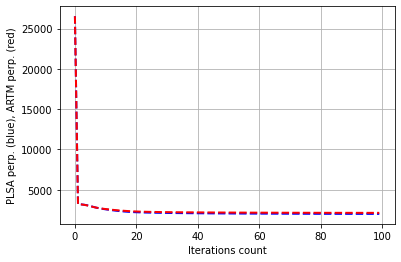

In [63]:
print('Sparsity Phi: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_rock.score_tracker['SparsityPhiScore'].last_value,
    model_artm_rock.score_tracker['SparsityPhiScore'].last_value))

print('Sparsity Theta: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_rock.score_tracker['SparsityThetaScore'].last_value,
    model_artm_rock.score_tracker['SparsityThetaScore'].last_value))

print('Kernel contrast: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_rock.score_tracker['TopicKernelScore'].last_average_contrast,
    model_artm_rock.score_tracker['TopicKernelScore'].last_average_contrast))

print('Kernel purity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_rock.score_tracker['TopicKernelScore'].last_average_purity,
    model_artm_rock.score_tracker['TopicKernelScore'].last_average_purity))

print('Perplexity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_rock.score_tracker['PerplexityScore'].last_value,
    model_artm_rock.score_tracker['PerplexityScore'].last_value))

plt.plot(range(model_plsa_rock.num_phi_updates),
            model_plsa_rock.score_tracker['PerplexityScore'].value, 'b--',
            range(model_artm_rock.num_phi_updates),
            model_artm_rock.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA perp. (blue), ARTM perp. (red)')
plt.grid(True)
plt.show()

#print(model_plsa, model_artm)

In [64]:
for topic_name in model_artm_rock.topic_names:
    print(topic_name + ': '),
    print(model_artm_rock.score_tracker['TopTokensScore'].last_tokens[topic_name])

Theme: 0: 
['lie', 'break', 'cry', 'something', 'inside', 'change', 'bring', 'high', 'free', 'hard']
Theme: 1: 
['nothing', 'lose', 'light', 'wait', 'walk', 'head', 'everything', 'alone', 'tonight', 'really']
Theme: 2: 
['doo', 'solo', 'bang', 'woo', 'vida', 'metal', 'ser', 'gimme', 'mary', 'banana']
Theme: 3: 
['rock', 'dance', 'play', 'boy', 'roll', 'people', 'put', 'everybody', 'woman', 'big']
Theme: 4: 
['god', 'please', 'song', 'sing', 'child', 'young', 'lover', 'mean', 'save', 'land']


In [65]:
for topic_name in model_plsa_rock.topic_names:
    print(topic_name + ': '),
    print(model_plsa_rock.score_tracker['TopTokensScore'].last_tokens[topic_name])

Theme: 0: 
['lie', 'break', 'cry', 'something', 'inside', 'change', 'bring', 'free', 'chorus', 'high']
Theme: 1: 
['nothing', 'lose', 'light', 'wait', 'walk', 'head', 'everything', 'alone', 'tonight', 'believe']
Theme: 2: 
['doo', 'solo', 'bang', 'woo', 'vida', 'ser', 'banana', 'quiero', 'corazón', 'leben']
Theme: 3: 
['rock', 'dance', 'play', 'boy', 'roll', 'put', 'people', 'everybody', 'woman', 'big']
Theme: 4: 
['god', 'please', 'song', 'sing', 'child', 'young', 'lover', 'save', 'mean', 'land']


###Latin: тематическое моделирование 

####LDA модель

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Latin.txt", data_format="vowpal_wabbit", target_folder="drive/My Drive/Colab Notebooks/Lyrics_Artm/Latin", 
                                       batch_size=1000)

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Latin", data_format='batches')

In [0]:
dict_latin = batch_vectorizer.dictionary

In [0]:
dict_latin = artm.Dictionary(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Latin")
dict_latin.gather(batch_vectorizer.data_path)

In [0]:
T = 5   # количество тем
lda_latin = artm.LDA(num_topics=T, alpha=0.05, beta=0.01, cache_theta=True,
               num_document_passes=5, dictionary=dict_latin)
lda_latin.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)

In [71]:
lda_latin.perplexity_value

[30772.501953125,
 4858.18017578125,
 4371.45556640625,
 3899.981201171875,
 3520.91455078125,
 3203.49365234375,
 2980.066650390625,
 2851.01806640625,
 2774.963134765625,
 2726.75732421875,
 2689.859130859375,
 2657.54150390625,
 2624.58203125,
 2590.230224609375,
 2562.9306640625,
 2543.421142578125,
 2526.480224609375,
 2512.41455078125,
 2500.742431640625,
 2491.11279296875,
 2482.750732421875,
 2475.50439453125,
 2468.54248046875,
 2463.212646484375,
 2458.832275390625,
 2454.778076171875,
 2451.115478515625,
 2448.480712890625,
 2446.218994140625,
 2443.940673828125,
 2441.677734375,
 2439.70654296875,
 2437.017822265625,
 2434.520263671875,
 2432.334228515625,
 2430.002685546875,
 2427.682373046875,
 2425.864501953125,
 2424.04248046875,
 2422.410400390625,
 2420.692138671875,
 2419.049560546875,
 2417.69384765625,
 2416.29296875,
 2415.1162109375,
 2413.992431640625,
 2413.044677734375,
 2412.1708984375,
 2410.322021484375,
 2409.288818359375,
 2408.6171875,
 2407.721435546875

In [72]:
top_tokens = lda_latin.get_top_tokens(num_tokens=10)
for i, token_list in enumerate(top_tokens):
     print('Topic #{0}: {1}'.format(i, token_list))

Topic #0: ['paso', 'noche', 'solo', 'llorar', 'vida', 'dios', 'pena', 'voy', 'hombre', 'gente']
Topic #1: ['dance', 'move', 'beat', 'body', 'chorus', 'party', 'cao', 'play', 'nothing', 'everything']
Topic #2: ['quiero', 'vida', 'corazón', 'solo', 'ser', 'siempre', 'vez', 'hoy', 'voy', 'tan']
Topic #3: ['ven', 'bailar', 'gusta', 'baila', 'dale', 'quiero', '¡', 'bien', 'ritmo', 'loco']
Topic #4: ['pra', 'vou', 'quero', 'vida', 'bem', 'tudo', 'mim', 'assim', 'coração', 'lá']


#### PLSA и ARTM модели

In [0]:
dict_latin = batch_vectorizer.dictionary

In [0]:
dict_latin = artm.Dictionary(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Latin")
dict_latin.gather(batch_vectorizer.data_path)

In [0]:
T = 5   # количество тем

model_plsa_latin = artm.ARTM(topic_names=["Theme: "+str(i) for i in range(T)], cache_theta=True, num_document_passes=1,
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dict_latin)])

model_artm_latin = artm.ARTM(num_topics=T, topic_names=["Theme: "+str(i) for i in range(T)], cache_theta=True,num_document_passes=1, scores=[artm.PerplexityScore(name='PerplexityScore', dictionary=dict_latin)],
                        regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.05)])

In [0]:
model_plsa_latin.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_plsa_latin.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_plsa_latin.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                            probability_mass_threshold=0.3))
model_plsa_latin.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))

model_artm_latin.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm_latin.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm_latin.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                                  probability_mass_threshold=0.3))
model_artm_latin.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))

model_artm_latin.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.05))
model_artm_latin.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=0.5e+5))

In [0]:
model_plsa_latin.initialize(dictionary=dict_latin)
model_artm_latin.initialize(dictionary=dict_latin)

In [0]:
model_plsa_latin.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)
model_artm_latin.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)

Sparsity Phi: 0.707 (PLSA) vs. 0.772 (ARTM)
Sparsity Theta: 0.039 (PLSA) vs. 0.100 (ARTM)
Kernel contrast: 0.914 (PLSA) vs. 0.941 (ARTM)
Kernel purity: 0.922 (PLSA) vs. 0.931 (ARTM)
Perplexity: 2640.236 (PLSA) vs. 2874.148 (ARTM)


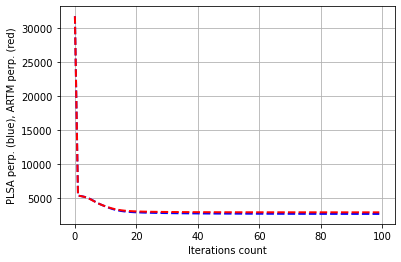

In [79]:
print('Sparsity Phi: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_latin.score_tracker['SparsityPhiScore'].last_value,
    model_artm_latin.score_tracker['SparsityPhiScore'].last_value))

print('Sparsity Theta: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_latin.score_tracker['SparsityThetaScore'].last_value,
    model_artm_latin.score_tracker['SparsityThetaScore'].last_value))

print('Kernel contrast: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_latin.score_tracker['TopicKernelScore'].last_average_contrast,
    model_artm_latin.score_tracker['TopicKernelScore'].last_average_contrast))

print('Kernel purity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_latin.score_tracker['TopicKernelScore'].last_average_purity,
    model_artm_latin.score_tracker['TopicKernelScore'].last_average_purity))

print('Perplexity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_latin.score_tracker['PerplexityScore'].last_value,
    model_artm_latin.score_tracker['PerplexityScore'].last_value))

plt.plot(range(model_plsa_latin.num_phi_updates),
            model_plsa_latin.score_tracker['PerplexityScore'].value, 'b--',
            range(model_artm_latin.num_phi_updates),
            model_artm_latin.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA perp. (blue), ARTM perp. (red)')
plt.grid(True)
plt.show()

#print(model_plsa, model_artm)

In [80]:
for topic_name in model_artm_latin.topic_names:
    print(topic_name + ': '),
    print(model_artm_latin.score_tracker['TopTokensScore'].last_tokens[topic_name])

Theme: 0: 
['solo', 'vez', 'vida', 'corazón', 'nunca', 'puedo', 'tan', 'vivir', 'nadie', 'dolor']
Theme: 1: 
['dance', 'beat', 'move', 'rock', 'party', 'body', 'chorus', 'play', 'cao', 'nothing']
Theme: 2: 
['quiero', 'vida', 'siempre', 'día', 'ser', 'sé', 'tiempo', 'cada', 'alma', 'hoy']
Theme: 3: 
['ven', 'voy', 'gusta', 'bailar', '¡', 'loco', 'bien', 'baila', 'gente', 'dale']
Theme: 4: 
['pra', 'vou', 'quero', 'vida', 'bem', 'ver', 'gente', 'mundo', 'tudo', 'mim']


In [81]:
for topic_name in model_plsa_latin.topic_names:
    print(topic_name + ': '),
    print(model_plsa_latin.score_tracker['TopTokensScore'].last_tokens[topic_name])

Theme: 0: 
['solo', 'corazón', 'vez', 'vida', 'nunca', 'tan', 'puedo', 'hoy', 'vivir', 'nadie']
Theme: 1: 
['dance', 'beat', 'move', 'rock', 'party', 'body', 'chorus', 'cao', 'play', 'nothing']
Theme: 2: 
['quiero', 'ser', 'vida', 'día', 'siempre', 'sé', 'tiempo', 'cada', 'alma', '¿']
Theme: 3: 
['ven', 'gusta', 'voy', 'bien', 'bailar', '¡', 'loco', 'baila', 'gente', 'dale']
Theme: 4: 
['pra', 'vou', 'quero', 'vida', 'bem', 'gente', 'ver', 'mundo', 'tudo', 'mim']


###Folk, World, & Country: тематическое моделирование 

####LDA модель

In [82]:
batch_vectorizer = artm.BatchVectorizer(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Folk, World, & Country.txt", data_format="vowpal_wabbit", target_folder="drive/My Drive/Colab Notebooks/Lyrics_Artm/Folk", 
                                       batch_size=1000)

InvalidOperationException: ignored

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Folk", data_format='batches')

In [0]:
dict_folk = batch_vectorizer.dictionary

In [0]:
dict_folk = artm.Dictionary(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Folk")
dict_folk.gather(batch_vectorizer.data_path)

In [0]:
T = 5   # количество тем
lda_folk = artm.LDA(num_topics=T, alpha=0.05, beta=0.01, cache_theta=True,
               num_document_passes=5, dictionary=dict_folk)
lda_folk.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)

In [87]:
lda_folk.perplexity_value

[19657.142578125,
 2509.550537109375,
 2326.581787109375,
 2155.087158203125,
 2015.1761474609375,
 1906.514892578125,
 1832.225830078125,
 1782.0419921875,
 1747.073974609375,
 1723.2664794921875,
 1704.301513671875,
 1688.810546875,
 1676.0260009765625,
 1664.4698486328125,
 1655.380859375,
 1647.842041015625,
 1641.91796875,
 1635.8701171875,
 1630.4193115234375,
 1625.38525390625,
 1621.0728759765625,
 1617.8697509765625,
 1614.833251953125,
 1611.850830078125,
 1608.9876708984375,
 1606.360107421875,
 1603.349365234375,
 1600.7337646484375,
 1598.8408203125,
 1597.207763671875,
 1595.704345703125,
 1594.180908203125,
 1592.4501953125,
 1590.81640625,
 1589.3330078125,
 1587.7178955078125,
 1585.89013671875,
 1584.41650390625,
 1583.0537109375,
 1581.8184814453125,
 1580.5479736328125,
 1579.287109375,
 1578.30859375,
 1577.1942138671875,
 1575.6907958984375,
 1574.7525634765625,
 1573.9122314453125,
 1573.1552734375,
 1572.423095703125,
 1571.7247314453125,
 1571.0181884765625,
 1

In [88]:
top_tokens = lda_folk.get_top_tokens(num_tokens=10)
for i, token_list in enumerate(top_tokens):
     print('Topic #{0}: {1}'.format(i, token_list))

Topic #0: ['cry', 'may', 'much', 'nothing', 'something', 'true', 'last', 'chorus', 'walk', 'lose']
Topic #1: ['sun', 'rain', 'sky', 'road', 'light', 'wind', 'sing', 'fly', 'blue', 'river']
Topic #2: ['vida', 'quiero', 'luz', 'solo', 'eta', 'gente', 'sol', 'pra', 'voy', 'cielo']
Topic #3: ['plus', 'bien', 'rien', "j'ai", 'vie', 'gué', "l'amour", 'temps', "qu'il", 'oui']
Topic #4: ['boy', 'town', 'big', 'daddy', 'country', 'dance', 'play', 'money', 'mama', 'round']


#### PLSA и ARTM модели

In [0]:
dict_folk = batch_vectorizer.dictionary

In [0]:
dict_folk = artm.Dictionary(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Folk")
dict_folk.gather(batch_vectorizer.data_path)

In [0]:
T = 5   # количество тем

model_plsa_folk = artm.ARTM(topic_names=["Theme: "+str(i) for i in range(T)], cache_theta=True, num_document_passes=1,
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dict_folk)])

model_artm_folk = artm.ARTM(num_topics=T, topic_names=["Theme: "+str(i) for i in range(T)], cache_theta=True,num_document_passes=1, scores=[artm.PerplexityScore(name='PerplexityScore', dictionary=dict_folk)],
                        regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.05)])

In [0]:
model_plsa_folk.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_plsa_folk.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_plsa_folk.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                            probability_mass_threshold=0.3))
model_plsa_folk.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))

model_artm_folk.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm_folk.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm_folk.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                                  probability_mass_threshold=0.3))
model_artm_folk.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))

model_artm_folk.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.05))
model_artm_folk.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=0.5e+5))

In [0]:
model_plsa_folk.initialize(dictionary=dict_folk)
model_artm_folk.initialize(dictionary=dict_folk)

In [0]:
model_plsa_folk.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)
model_artm_folk.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)

Sparsity Phi: 0.687 (PLSA) vs. 0.780 (ARTM)
Sparsity Theta: 0.053 (PLSA) vs. 0.102 (ARTM)
Kernel contrast: 0.910 (PLSA) vs. 0.955 (ARTM)
Kernel purity: 0.931 (PLSA) vs. 0.940 (ARTM)
Perplexity: 1673.808 (PLSA) vs. 1819.253 (ARTM)


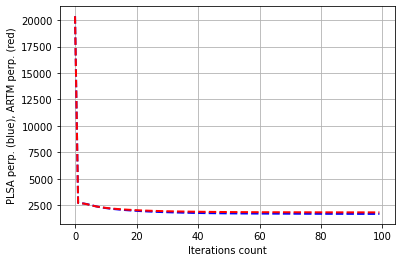

In [95]:
print('Sparsity Phi: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_folk.score_tracker['SparsityPhiScore'].last_value,
    model_artm_folk.score_tracker['SparsityPhiScore'].last_value))

print('Sparsity Theta: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_folk.score_tracker['SparsityThetaScore'].last_value,
    model_artm_folk.score_tracker['SparsityThetaScore'].last_value))

print('Kernel contrast: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_folk.score_tracker['TopicKernelScore'].last_average_contrast,
    model_artm_folk.score_tracker['TopicKernelScore'].last_average_contrast))

print('Kernel purity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_folk.score_tracker['TopicKernelScore'].last_average_purity,
    model_artm_folk.score_tracker['TopicKernelScore'].last_average_purity))

print('Perplexity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_folk.score_tracker['PerplexityScore'].last_value,
    model_artm_folk.score_tracker['PerplexityScore'].last_value))

plt.plot(range(model_plsa_folk.num_phi_updates),
            model_plsa_folk.score_tracker['PerplexityScore'].value, 'b--',
            range(model_artm_folk.num_phi_updates),
            model_artm_folk.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA perp. (blue), ARTM perp. (red)')
plt.grid(True)
plt.show()

#print(model_plsa, model_artm)

In [96]:
for topic_name in model_artm_folk.topic_names:
    print(topic_name + ': '),
    print(model_artm_folk.score_tracker['TopTokensScore'].last_tokens[topic_name])

Theme: 0: 
['cry', 'chorus', 'blue', 'may', 'last', 'much', 'something', 'tonight', 'lose', 'nothing']
Theme: 1: 
['light', 'walk', 'sun', 'lord', 'stand', 'place', 'rain', 'sky', 'cold', 'morning']
Theme: 2: 
['vida', 'king', 'babe', 'fallin', 'bien', 'solo', 'quiero', 'luz', 'beautiful', 'sol']
Theme: 3: 
['town', 'boy', 'big', 'woman', 'dance', 'ride', 'roll', 'daddy', 'round', 'work']
Theme: 4: 
['song', 'sing', 'sweet', 'road', 'friend', 'bring', 'year', 'side', 'god', 'please']


In [97]:
for topic_name in model_plsa_folk.topic_names:
    print(topic_name + ': '),
    print(model_plsa_folk.score_tracker['TopTokensScore'].last_tokens[topic_name])

Theme: 0: 
['cry', 'chorus', 'nothing', 'much', 'last', 'may', 'blue', 'something', 'tonight', 'lose']
Theme: 1: 
['light', 'sun', 'walk', 'lord', 'rain', 'place', 'sky', 'cold', 'morning', 'watch']
Theme: 2: 
['vida', 'king', 'babe', 'solo', 'quiero', 'luz', 'eta', 'sol', 'gente', 'pra']
Theme: 3: 
['town', 'big', 'boy', 'dance', 'ride', 'roll', 'daddy', 'country', 'rock', 'mama']
Theme: 4: 
['song', 'sing', 'sweet', 'road', 'friend', 'year', 'bring', 'side', 'please', 'god']


###Electronic: тематическое моделирование 

####LDA модель

In [98]:
batch_vectorizer = artm.BatchVectorizer(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Electronic.txt", data_format="vowpal_wabbit", target_folder="drive/My Drive/Colab Notebooks/Lyrics_Artm/Electronic", 
                                       batch_size=1000)

InvalidOperationException: ignored

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Electronic", data_format='batches')

In [0]:
dict_electronic = batch_vectorizer.dictionary

In [0]:
dict_electronic = artm.Dictionary(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Electronic")
dict_electronic.gather(batch_vectorizer.data_path)

In [0]:
T = 5   # количество тем
lda_electronic = artm.LDA(num_topics=T, alpha=0.05, beta=0.01, cache_theta=True,
               num_document_passes=5, dictionary=dict_electronic)
lda_electronic.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)

In [103]:
lda_electronic.perplexity_value

[23918.412109375,
 2753.99072265625,
 2540.406982421875,
 2363.369140625,
 2248.4794921875,
 2168.1083984375,
 2092.482666015625,
 2026.6690673828125,
 1972.409912109375,
 1929.72412109375,
 1895.488525390625,
 1871.6163330078125,
 1853.46533203125,
 1838.0738525390625,
 1825.3709716796875,
 1813.932373046875,
 1802.84912109375,
 1792.8289794921875,
 1783.917236328125,
 1775.64453125,
 1767.7847900390625,
 1761.0970458984375,
 1755.958251953125,
 1751.371337890625,
 1747.33203125,
 1743.8775634765625,
 1740.431396484375,
 1737.262939453125,
 1734.8702392578125,
 1732.455322265625,
 1730.1282958984375,
 1727.8720703125,
 1725.8392333984375,
 1723.92919921875,
 1722.093017578125,
 1720.3416748046875,
 1718.421875,
 1716.5242919921875,
 1714.533447265625,
 1712.2591552734375,
 1710.5316162109375,
 1708.572021484375,
 1706.2503662109375,
 1704.41162109375,
 1702.6201171875,
 1700.6702880859375,
 1698.87548828125,
 1697.077392578125,
 1694.98046875,
 1693.37353515625,
 1692.34912109375,
 16

In [104]:
top_tokens = lda_electronic.get_top_tokens(num_tokens=10)
for i, token_list in enumerate(top_tokens):
     print('Topic #{0}: {1}'.format(i, token_list))

Topic #0: ['dance', 'rock', 'boy', 'body', 'shake', 'move', 'music', 'beat', 'stop', 'roll']
Topic #1: ['nothing', 'light', 'lose', 'something', 'wait', 'walk', 'much', 'inside', 'really', 'sun']
Topic #2: ['woo', 'doo', 'quiero', 'gimme', 'solo', 'bum', 'vida', '¿', 'corazón', 'hello']
Topic #3: ['boom', 'bye', 'yeh', 'dub', 'plus', 'nie', 'immer', 'mehr', 'shy', 'leben']
Topic #4: ['new', 'money', 'black', 'wild', 'work', 'play', 'head', 'red', 'must', 'people']


#### PLSA и ARTM модели

In [0]:
dict_electronic = batch_vectorizer.dictionary

In [0]:
dict_electronic = artm.Dictionary(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Electronic")
dict_electronic.gather(batch_vectorizer.data_path)

In [0]:
T = 5   # количество тем

model_plsa_electronic = artm.ARTM(topic_names=["Theme: "+str(i) for i in range(T)], cache_theta=True, num_document_passes=1,
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dict_electronic)])

model_artm_electronic = artm.ARTM(num_topics=T, topic_names=["Theme: "+str(i) for i in range(T)], cache_theta=True,num_document_passes=1, scores=[artm.PerplexityScore(name='PerplexityScore', dictionary=dict_electronic)],
                        regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.05)])

In [0]:
model_plsa_electronic.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_plsa_electronic.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_plsa_electronic.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                            probability_mass_threshold=0.3))
model_plsa_electronic.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))

model_artm_electronic.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm_electronic.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm_electronic.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                                  probability_mass_threshold=0.3))
model_artm_electronic.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))

model_artm_electronic.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.05))
model_artm_electronic.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=0.5e+5))

In [0]:
model_plsa_electronic.initialize(dictionary=dict_electronic)
model_artm_electronic.initialize(dictionary=dict_electronic)

In [0]:
model_plsa_electronic.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)
model_artm_electronic.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)

In [111]:
print('Sparsity Phi: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_electronic.score_tracker['SparsityPhiScore'].last_value,
    model_artm_electronic.score_tracker['SparsityPhiScore'].last_value))

print('Sparsity Theta: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_electronic.score_tracker['SparsityThetaScore'].last_value,
    model_artm_electronic.score_tracker['SparsityThetaScore'].last_value))

print('Kernel contrast: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_electronic.score_tracker['TopicKernelScore'].last_average_contrast,
    model_artm_electronic.score_tracker['TopicKernelScore'].last_average_contrast))

print('Kernel purity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_electronic.score_tracker['TopicKernelScore'].last_average_purity,
    model_artm_electronic.score_tracker['TopicKernelScore'].last_average_purity))

print('Perplexity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_electronic.score_tracker['PerplexityScore'].last_value,
    model_artm_electronic.score_tracker['PerplexityScore'].last_value))

plt.plot(range(model_plsa_electronic.num_phi_updates),
            model_plsa_electronic.score_tracker['PerplexityScore'].value, 'b--',
            range(model_artm_electronic.num_phi_updates),
            model_artm_electronic.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA perp. (blue), ARTM perp. (red)')
plt.grid(True)
plt.show()

#print(model_plsa, model_artm)

Sparsity Phi: 0.684 (PLSA) vs. 0.776 (ARTM)
Sparsity Theta: 0.029 (PLSA) vs. 0.082 (ARTM)
Kernel contrast: 0.904 (PLSA) vs. 0.950 (ARTM)
Kernel purity: 0.936 (PLSA) vs. 0.945 (ARTM)
Perplexity: 1837.784 (PLSA) vs. 1984.754 (ARTM)


In [112]:
for topic_name in model_artm_electronic.topic_names:
    print(topic_name + ': '),
    print(model_artm_electronic.score_tracker['TopTokensScore'].last_tokens[topic_name])

Theme: 0: 
['something', 'tonight', 'move', 'show', 'play', 'high', 'break', 'much', 'stay', 'change']
Theme: 1: 
['lose', 'light', 'wait', 'walk', 'head', 'everything', 'lie', 'inside', 'place', 'alone']
Theme: 2: 
['woo', 'sun', 'bit', 'moon', 'bang', 'shine', 'summer', 'slow', 'gimme', 'doo']
Theme: 3: 
['dance', 'boy', 'stop', 'beat', 'rock', 'new', 'big', 'music', 'money', 'roll']
Theme: 4: 
['must', 'bad', 'wild', 'air', 'young', 'black', 'late', 'fade', 'write', 'miss']


In [113]:
for topic_name in model_plsa_electronic.topic_names:
    print(topic_name + ': '),
    print(model_plsa_electronic.score_tracker['TopTokensScore'].last_tokens[topic_name])

Theme: 0: 
['something', 'tonight', 'show', 'really', 'high', 'move', 'play', 'much', 'break', 'stay']
Theme: 1: 
['lose', 'wait', 'light', 'walk', 'everything', 'head', 'sun', 'lie', 'inside', 'place']
Theme: 2: 
['woo', 'bang', 'gimme', 'doo', 'quiero', 'hello', 'solo', 'summer', 'bum', 'plus']
Theme: 3: 
['dance', 'boy', 'stop', 'beat', 'rock', 'shake', 'new', 'big', 'music', 'money']
Theme: 4: 
['must', 'bad', 'wild', 'air', 'black', 'young', 'red', 'light', 'kind', 'fade']


###Reggae: тематическое моделирование 

####LDA модель

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Reggae.txt", data_format="vowpal_wabbit", target_folder="drive/My Drive/Colab Notebooks/Lyrics_Artm/Reggae", 
                                       batch_size=1000)

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Reggae", data_format='batches')

In [0]:
dict_reggae = batch_vectorizer.dictionary

In [0]:
dict_reggae = artm.Dictionary(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Reggae")
dict_reggae.gather(batch_vectorizer.data_path)

In [0]:
T = 5   # количество тем
lda_reggae = artm.LDA(num_topics=T, alpha=0.05, beta=0.01, cache_theta=True,
               num_document_passes=5, dictionary=dict_reggae)
lda_reggae.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)

In [119]:
lda_reggae.perplexity_value

[15445.0498046875,
 2586.7998046875,
 2298.847900390625,
 2063.29150390625,
 1905.2349853515625,
 1805.7825927734375,
 1740.41650390625,
 1698.062255859375,
 1668.079833984375,
 1647.2713623046875,
 1631.4921875,
 1619.242431640625,
 1608.1263427734375,
 1597.64013671875,
 1587.295654296875,
 1578.86474609375,
 1571.2606201171875,
 1563.0794677734375,
 1554.867431640625,
 1546.4307861328125,
 1538.1949462890625,
 1532.36181640625,
 1528.96533203125,
 1526.27587890625,
 1523.8218994140625,
 1520.557861328125,
 1516.484130859375,
 1513.0726318359375,
 1508.4266357421875,
 1504.5262451171875,
 1502.15380859375,
 1500.3917236328125,
 1498.507080078125,
 1496.9791259765625,
 1495.4940185546875,
 1494.3502197265625,
 1493.5943603515625,
 1492.939208984375,
 1492.1632080078125,
 1491.13134765625,
 1489.444580078125,
 1488.2464599609375,
 1487.70068359375,
 1487.02783203125,
 1486.0465087890625,
 1485.0828857421875,
 1484.4964599609375,
 1484.0484619140625,
 1483.55615234375,
 1483.24743652343

In [120]:
top_tokens = lda_reggae.get_top_tokens(num_tokens=10)
for i, token_list in enumerate(top_tokens):
     print('Topic #{0}: {1}'.format(i, token_list))

Topic #0: ['boy', 'chorus', 'lover', 'mama', 'nobody', 'bad', 'wait', 'crazy', 'two', 'start']
Topic #1: ['jah', 'people', 'cry', 'lord', 'stand', 'fight', 'yes', 'friend', 'everything', 'soul']
Topic #2: ['yuh', 'nuh', 'inna', 'pon', 'gal', 'mek', 'seh', 'deh', 'gyal', 'weh']
Topic #3: ['music', 'reggae', 'dance', 'wine', 'boom', 'gal', 'rock', 'sweet', 'shake', 'body']
Topic #4: ['bubble', 'pra', 'butt', 'vida', 'tudo', 'fighting', 'limbo', 'plus', 'bien', 'tempo']


#### PLSA и ARTM модели

In [0]:
dict_reggae = batch_vectorizer.dictionary

In [0]:
dict_reggae = artm.Dictionary(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Reggae")
dict_reggae.gather(batch_vectorizer.data_path)

In [0]:
T = 5   # количество тем

model_plsa_reggae = artm.ARTM(topic_names=["Theme: "+str(i) for i in range(T)], cache_theta=True, num_document_passes=1,
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dict_reggae)])

model_artm_reggae = artm.ARTM(num_topics=T, topic_names=["Theme: "+str(i) for i in range(T)], cache_theta=True,num_document_passes=1, scores=[artm.PerplexityScore(name='PerplexityScore', dictionary=dict_reggae)],
                        regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.05)])

In [0]:
model_plsa_reggae.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_plsa_reggae.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_plsa_reggae.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                            probability_mass_threshold=0.3))
model_plsa_reggae.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))

model_artm_reggae.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm_reggae.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm_reggae.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                                  probability_mass_threshold=0.3))
model_artm_reggae.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))

model_artm_reggae.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.05))
model_artm_reggae.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=0.5e+5))

In [0]:
model_plsa_reggae.initialize(dictionary=dict_reggae)
model_artm_reggae.initialize(dictionary=dict_reggae)

In [0]:
model_plsa_reggae.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)
model_artm_reggae.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)

In [127]:
print('Sparsity Phi: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_reggae.score_tracker['SparsityPhiScore'].last_value,
    model_artm_reggae.score_tracker['SparsityPhiScore'].last_value))

print('Sparsity Theta: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_reggae.score_tracker['SparsityThetaScore'].last_value,
    model_artm_reggae.score_tracker['SparsityThetaScore'].last_value))

print('Kernel contrast: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_reggae.score_tracker['TopicKernelScore'].last_average_contrast,
    model_artm_reggae.score_tracker['TopicKernelScore'].last_average_contrast))

print('Kernel purity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_reggae.score_tracker['TopicKernelScore'].last_average_purity,
    model_artm_reggae.score_tracker['TopicKernelScore'].last_average_purity))

print('Perplexity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_reggae.score_tracker['PerplexityScore'].last_value,
    model_artm_reggae.score_tracker['PerplexityScore'].last_value))

plt.plot(range(model_plsa_reggae.num_phi_updates),
            model_plsa_reggae.score_tracker['PerplexityScore'].value, 'b--',
            range(model_artm_reggae.num_phi_updates),
            model_artm_reggae.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA perp. (blue), ARTM perp. (red)')
plt.grid(True)
plt.show()

#print(model_plsa, model_artm)

Sparsity Phi: 0.698 (PLSA) vs. 0.759 (ARTM)
Sparsity Theta: 0.022 (PLSA) vs. 0.038 (ARTM)
Kernel contrast: 0.895 (PLSA) vs. 0.914 (ARTM)
Kernel purity: 0.919 (PLSA) vs. 0.920 (ARTM)
Perplexity: 1612.609 (PLSA) vs. 1712.105 (ARTM)


In [128]:
for topic_name in model_artm_reggae.topic_names:
    print(topic_name + ': '),
    print(model_artm_reggae.score_tracker['TopTokensScore'].last_tokens[topic_name])

Theme: 0: 
['chorus', 'boy', 'nothing', 'stay', 'wait', 'lie', 'even', 'mama', 'true', 'may']
Theme: 1: 
['jah', 'people', 'stand', 'lord', 'fight', 'fire', 'soul', 'child', 'youth', 'burn']
Theme: 2: 
['yuh', 'gal', 'nuh', 'inna', 'pon', 'mek', 'wine', 'seh', 'deh', 'red']
Theme: 3: 
['cry', 'woman', 'rock', 'sweet', 'move', 'music', 'dance', 'play', 'reggae', 'boom']
Theme: 4: 
['hot', 'bubble', 'crazy', 'pra', 'cool', 'chase', 'butt', 'fighting', 'vida', 'gwaan']


In [129]:
for topic_name in model_plsa_reggae.topic_names:
    print(topic_name + ': '),
    print(model_plsa_reggae.score_tracker['TopTokensScore'].last_tokens[topic_name])

Theme: 0: 
['chorus', 'boy', 'nothing', 'stay', 'wait', 'lie', 'even', 'mama', 'true', 'may']
Theme: 1: 
['jah', 'people', 'lord', 'stand', 'fight', 'fire', 'child', 'free', 'soul', 'black']
Theme: 2: 
['yuh', 'gal', 'nuh', 'inna', 'pon', 'mek', 'wine', 'hot', 'seh', 'deh']
Theme: 3: 
['cry', 'woman', 'rock', 'sweet', 'move', 'music', 'dance', 'play', 'reggae', 'boom']
Theme: 4: 
['bubble', 'crazy', 'pra', 'butt', 'fighting', 'vida', 'tudo', 'plus', 'chase', 'rebel']


###Blues: тематическое моделирование 

####LDA модель

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Blues.txt", data_format="vowpal_wabbit", target_folder="drive/My Drive/Colab Notebooks/Lyrics_Artm/Blues", 
                                       batch_size=1000)

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Blues", data_format='batches')

In [0]:
dict_blues = batch_vectorizer.dictionary

In [0]:
dict_blues = artm.Dictionary(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Blues")
dict_blues.gather(batch_vectorizer.data_path)

In [0]:
T = 5   # количество тем
lda_blues = artm.LDA(num_topics=T, alpha=0.05, beta=0.01, cache_theta=True,
               num_document_passes=5, dictionary=dict_blues)
lda_blues.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)

In [135]:
lda_blues.perplexity_value

[10409.5625,
 1668.861328125,
 1522.1397705078125,
 1424.99560546875,
 1366.720947265625,
 1330.135009765625,
 1305.99462890625,
 1288.2548828125,
 1274.5755615234375,
 1263.954833984375,
 1255.4278564453125,
 1248.2882080078125,
 1242.328369140625,
 1237.29833984375,
 1232.9598388671875,
 1229.1162109375,
 1225.1417236328125,
 1221.41015625,
 1217.9345703125,
 1214.7994384765625,
 1212.2435302734375,
 1209.890625,
 1207.676025390625,
 1205.627685546875,
 1203.6007080078125,
 1201.516357421875,
 1199.364501953125,
 1197.2657470703125,
 1195.775634765625,
 1194.3277587890625,
 1192.896484375,
 1191.427734375,
 1189.9449462890625,
 1188.578125,
 1186.9971923828125,
 1185.5482177734375,
 1184.2125244140625,
 1183.059814453125,
 1182.2198486328125,
 1181.427490234375,
 1180.5201416015625,
 1179.4534912109375,
 1178.7166748046875,
 1178.1156005859375,
 1177.5367431640625,
 1176.959228515625,
 1176.2901611328125,
 1175.346923828125,
 1174.7340087890625,
 1174.2452392578125,
 1173.81079101562

In [136]:
top_tokens = lda_blues.get_top_tokens(num_tokens=10)
for i, token_list in enumerate(top_tokens):
     print('Topic #{0}: {1}'.format(i, token_list))

Topic #0: ['cry', 'sweet', 'blue', 'may', 'please', 'wait', 'alone', 'break', 'wrong', 'true']
Topic #1: ['woman', 'lord', 'yes', 'blue', 'money', 'bad', 'please', 'morning', 'treat', 'babe']
Topic #2: ['nobody', 'sun', 'shine', 'black', 'light', 'diddley', 'red', 'road', 'hot', 'sure']
Topic #3: ['rock', 'roll', 'mama', 'music', 'jump', 'dance', 'sweet', 'shake', 'papa', 'sugar']
Topic #4: ['honey', 'fine', 'big', 'god', 'boy', 'bye', 'wild', 'boogie', 'town', 'crazy']


#### PLSA и ARTM модели

In [0]:
dict_blues = batch_vectorizer.dictionary

In [0]:
dict_blues = artm.Dictionary(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/Blues")
dict_blues.gather(batch_vectorizer.data_path)

In [0]:
T = 5   # количество тем

model_plsa_blues = artm.ARTM(topic_names=["Theme: "+str(i) for i in range(T)], cache_theta=True, num_document_passes=1,
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dict_blues)])

model_artm_blues = artm.ARTM(num_topics=T, topic_names=["Theme: "+str(i) for i in range(T)], cache_theta=True,num_document_passes=1, scores=[artm.PerplexityScore(name='PerplexityScore', dictionary=dict_blues)],
                        regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.05)])

In [0]:
model_plsa_blues.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_plsa_blues.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_plsa_blues.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                            probability_mass_threshold=0.3))
model_plsa_blues.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))

model_artm_blues.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm_blues.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm_blues.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                                  probability_mass_threshold=0.3))
model_artm_blues.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))

model_artm_blues.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.05))
model_artm_blues.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=0.5e+5))

In [0]:
model_plsa_blues.initialize(dictionary=dict_blues)
model_artm_blues.initialize(dictionary=dict_blues)

In [0]:
model_plsa_blues.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)
model_artm_blues.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)

In [143]:
print('Sparsity Phi: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_blues.score_tracker['SparsityPhiScore'].last_value,
    model_artm_blues.score_tracker['SparsityPhiScore'].last_value))

print('Sparsity Theta: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_blues.score_tracker['SparsityThetaScore'].last_value,
    model_artm_blues.score_tracker['SparsityThetaScore'].last_value))

print('Kernel contrast: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_blues.score_tracker['TopicKernelScore'].last_average_contrast,
    model_artm_blues.score_tracker['TopicKernelScore'].last_average_contrast))

print('Kernel purity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_blues.score_tracker['TopicKernelScore'].last_average_purity,
    model_artm_blues.score_tracker['TopicKernelScore'].last_average_purity))

print('Perplexity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_blues.score_tracker['PerplexityScore'].last_value,
    model_artm_blues.score_tracker['PerplexityScore'].last_value))

plt.plot(range(model_plsa_blues.num_phi_updates),
            model_plsa_blues.score_tracker['PerplexityScore'].value, 'b--',
            range(model_artm_blues.num_phi_updates),
            model_artm_blues.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA perp. (blue), ARTM perp. (red)')
plt.grid(True)
plt.show()

#print(model_plsa, model_artm)

Sparsity Phi: 0.647 (PLSA) vs. 0.755 (ARTM)
Sparsity Theta: 0.003 (PLSA) vs. 0.012 (ARTM)
Kernel contrast: 0.895 (PLSA) vs. 0.920 (ARTM)
Kernel purity: 0.900 (PLSA) vs. 0.908 (ARTM)
Perplexity: 1293.702 (PLSA) vs. 1310.584 (ARTM)


In [144]:
for topic_name in model_artm_blues.topic_names:
    print(topic_name + ': '),
    print(model_artm_blues.score_tracker['TopTokensScore'].last_tokens[topic_name])

Theme: 0: 
['cry', 'wrong', 'lie', 'nothing', 'wait', 'play', 'break', 'last', 'move', 'use']
Theme: 1: 
['yes', 'lord', 'bad', 'people', 'money', 'woman', 'lose', 'new', 'big', 'walk']
Theme: 2: 
['nobody', 'light', 'sun', 'morning', 'somebody', 'black', 'sure', 'chorus', 'rain', 'road']
Theme: 3: 
['blue', 'rock', 'woman', 'roll', 'sweet', 'mama', 'boy', 'treat', 'mean', 'child']
Theme: 4: 
['please', 'alone', 'honey', 'stand', 'bring', 'soul', 'god', 'miss', 'fine', 'free']


In [145]:
for topic_name in model_plsa_blues.topic_names:
    print(topic_name + ': '),
    print(model_plsa_blues.score_tracker['TopTokensScore'].last_tokens[topic_name])

Theme: 0: 
['cry', 'wrong', 'lie', 'nothing', 'break', 'play', 'move', 'last', 'wait', 'use']
Theme: 1: 
['yes', 'lord', 'woman', 'bad', 'people', 'money', 'new', 'big', 'town', 'shake']
Theme: 2: 
['nobody', 'sun', 'light', 'morning', 'somebody', 'black', 'sure', 'chorus', 'rain', 'road']
Theme: 3: 
['blue', 'rock', 'roll', 'mama', 'sweet', 'boy', 'treat', 'tonight', 'mean', 'child']
Theme: 4: 
['please', 'alone', 'honey', 'stand', 'bring', 'soul', 'god', 'miss', 'fine', 'free']


##Тематическое моделирование песен всего набора данных

In [0]:
repl = '"!.?¿\'«»#№$%&()*+,-—/:;<=>@[\\]^_`{|}~0123456789'

with open('drive/My Drive/Colab Notebooks/Lyrics_Artm/All_songs.txt', 'wt') as f:
    for song in X_tok:
        one_song = ''
        for token in song:
            if token in repl or token in uninformative or token in stopwords_pypl or token in stopwords or token in frequency_excluded:
                continue
            one_song = one_song + token + ' '
        f.write('|text {}\n'.format(one_song))

####LDA модель

In [147]:
batch_vectorizer = artm.BatchVectorizer(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/All_songs.txt", data_format="vowpal_wabbit", target_folder="drive/My Drive/Colab Notebooks/Lyrics_Artm/All_songs", 
                                       batch_size=1000)

InvalidOperationException: ignored

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/All_songs", data_format='batches')

In [0]:
dict_all = batch_vectorizer.dictionary

In [0]:
dict_all = artm.Dictionary(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/All_songs")
dict_all.gather(batch_vectorizer.data_path)

In [0]:
T = 5   # количество тем
lda_all = artm.LDA(num_topics=T, alpha=0.05, beta=0.01, cache_theta=True,
               num_document_passes=5, dictionary=dict_all)
lda_all.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)

In [152]:
lda_all.perplexity_value

[31519.037109375,
 2674.984375,
 2513.568603515625,
 2368.65576171875,
 2259.35302734375,
 2175.661865234375,
 2103.6181640625,
 2045.129638671875,
 2000.9476318359375,
 1969.552490234375,
 1945.9285888671875,
 1927.260986328125,
 1910.670166015625,
 1897.7818603515625,
 1886.369873046875,
 1875.89111328125,
 1866.7401123046875,
 1858.79443359375,
 1851.8084716796875,
 1845.5888671875,
 1839.592041015625,
 1833.7376708984375,
 1828.39111328125,
 1823.3563232421875,
 1818.842041015625,
 1814.8212890625,
 1811.0626220703125,
 1807.5628662109375,
 1804.0194091796875,
 1800.548095703125,
 1797.3048095703125,
 1794.2318115234375,
 1791.0252685546875,
 1787.6683349609375,
 1784.1175537109375,
 1780.40234375,
 1776.1492919921875,
 1772.3507080078125,
 1769.230712890625,
 1766.43896484375,
 1763.313720703125,
 1760.0980224609375,
 1757.4144287109375,
 1754.638427734375,
 1751.806396484375,
 1749.202880859375,
 1746.8817138671875,
 1744.5777587890625,
 1742.4049072265625,
 1740.3028564453125,
 

In [153]:
top_tokens = lda_all.get_top_tokens(num_tokens=10)
for i, token_list in enumerate(top_tokens):
     print('Topic #{0}: {1}'.format(i, token_list))

Topic #0: ['dance', 'move', 'chorus', 'stop', 'play', 'body', 'shake', 'show', 'music', 'tonight']
Topic #1: ['blue', 'cry', 'lord', 'lose', 'walk', 'light', 'please', 'alone', 'sun', 'yes']
Topic #2: ['woo', 'solo', 'diddley', 'quiero', 'vida', 'dee', 'sempre', 'ser', 'vita', 'sol']
Topic #3: ['rock', 'roll', 'boogie', 'boom', 'bop', 'plus', 'oui', 'yeh', 'henry', 'irene']
Topic #4: ['boy', 'big', 'woman', 'money', 'mama', 'town', 'ride', 'black', 'jump', 'roll']


#### PLSA и ARTM модели

In [0]:
dict_all = batch_vectorizer.dictionary

In [0]:
dict_all = artm.Dictionary(data_path="drive/My Drive/Colab Notebooks/Lyrics_Artm/All_songs")
dict_all.gather(batch_vectorizer.data_path)

In [0]:
T = 5   # количество тем

model_plsa_all = artm.ARTM(topic_names=["Theme: "+str(i) for i in range(T)], cache_theta=True, num_document_passes=1,
                       scores=[artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dict_all)])

model_artm_all = artm.ARTM(num_topics=T, topic_names=["Theme: "+str(i) for i in range(T)], cache_theta=True,num_document_passes=1, scores=[artm.PerplexityScore(name='PerplexityScore', dictionary=dict_all)],
                        regularizers=[artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.05)])

In [0]:
model_plsa_all.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_plsa_all.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_plsa_all.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                            probability_mass_threshold=0.3))
model_plsa_all.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))

model_artm_all.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm_all.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm_all.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                                  probability_mass_threshold=0.3))
model_artm_all.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))

model_artm_all.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.05))
model_artm_all.regularizers.add(artm.DecorrelatorPhiRegularizer(name='DecorrelatorPhi', tau=0.5e+5))

In [0]:
model_plsa_all.initialize(dictionary=dict_all)
model_artm_all.initialize(dictionary=dict_all)

In [0]:
model_plsa_all.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)
model_artm_all.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=100)

In [160]:
print('Sparsity Phi: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_all.score_tracker['SparsityPhiScore'].last_value,
    model_artm_all.score_tracker['SparsityPhiScore'].last_value))

print('Sparsity Theta: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_all.score_tracker['SparsityThetaScore'].last_value,
    model_artm_all.score_tracker['SparsityThetaScore'].last_value))

print('Kernel contrast: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_all.score_tracker['TopicKernelScore'].last_average_contrast,
    model_artm_all.score_tracker['TopicKernelScore'].last_average_contrast))

print('Kernel purity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_all.score_tracker['TopicKernelScore'].last_average_purity,
    model_artm_all.score_tracker['TopicKernelScore'].last_average_purity))

print('Perplexity: {0:.3f} (PLSA) vs. {1:.3f} (ARTM)'.format(
    model_plsa_all.score_tracker['PerplexityScore'].last_value,
    model_artm_all.score_tracker['PerplexityScore'].last_value))

plt.plot(range(model_plsa_all.num_phi_updates),
            model_plsa_all.score_tracker['PerplexityScore'].value, 'b--',
            range(model_artm_all.num_phi_updates),
            model_artm_all.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA perp. (blue), ARTM perp. (red)')
plt.grid(True)
plt.show()

#print(model_plsa, model_artm)

Sparsity Phi: 0.680 (PLSA) vs. 0.777 (ARTM)
Sparsity Theta: 0.019 (PLSA) vs. 0.072 (ARTM)
Kernel contrast: 0.915 (PLSA) vs. 0.953 (ARTM)
Kernel purity: 0.928 (PLSA) vs. 0.936 (ARTM)
Perplexity: 1896.113 (PLSA) vs. 2003.727 (ARTM)


In [161]:
for topic_name in model_artm_all.topic_names:
    print(topic_name + ': '),
    print(model_artm_all.score_tracker['TopTokensScore'].last_tokens[topic_name])

Theme: 0: 
['something', 'break', 'nothing', 'really', 'tonight', 'much', 'wait', 'move', 'stop', 'lie']
Theme: 1: 
['blue', 'yes', 'walk', 'lose', 'lord', 'alone', 'head', 'stand', 'bad', 'people']
Theme: 2: 
['nobody', 'sun', 'shine', 'moon', 'somebody', 'woo', 'beautiful', 'doo', 'bit', 'black']
Theme: 3: 
['boy', 'dance', 'woman', 'rock', 'roll', 'big', 'money', 'mama', 'everybody', 'work']
Theme: 4: 
['light', 'please', 'must', 'friend', 'real', 'miss', 'open', 'star', 'honey', 'god']


In [162]:
for topic_name in model_plsa_all.topic_names:
    print(topic_name + ': '),
    print(model_plsa_all.score_tracker['TopTokensScore'].last_tokens[topic_name])

Theme: 0: 
['something', 'nothing', 'break', 'stop', 'really', 'tonight', 'much', 'wait', 'move', 'lie']
Theme: 1: 
['blue', 'yes', 'walk', 'lord', 'lose', 'head', 'alone', 'stand', 'bad', 'people']
Theme: 2: 
['nobody', 'woo', 'shine', 'doo', 'bit', 'beautiful', 'bang', 'gimme', 'sun', 'solo']
Theme: 3: 
['boy', 'dance', 'rock', 'roll', 'big', 'woman', 'money', 'mama', 'ride', 'everybody']
Theme: 4: 
['light', 'please', 'must', 'friend', 'miss', 'real', 'star', 'open', 'honey', 'god']
